In [1]:
import cv2
import numpy as np
import glob
import pickle
from tracker import tracker
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [2]:
calibFile = 'calibration_pickle.p'
camerCalib = pickle.load(open(calibFile,'rb'))

mtx = camerCalib["mtx"]
dist = camerCalib["dist"]

In [3]:
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary) == 1] = 1

    # Return the combined s_channel & v_channel binary image
    return output

def s_channel_threshold(image, sthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]  # use S channel

    # create a copy and apply the threshold
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    return binary_output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), 
           max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    print ("Level {}, mask Slice {}: ".format(level, (int(img_ref.shape[0]-(level+1.5)*height), int(img_ref.shape[0]-level*height), 
           max(0,int(center-width)), min(int(center+width),img_ref.shape[1]))))
    return output

import numba as nb # for fast looping through image array
@nb.njit()
def remove_nonLaneLine(T, image_data):
    # grab the image dimensions
    maskImg = np.copy(image_data)
    for y in range(0,image_data.shape[0]):
        for x in range(0,image_data.shape[1]):
            # threshold the pixel
            if maskImg[y, x] <= T:
                maskImg[y, x] = 255 
            else:
               maskImg[y, x] = 0  
    return maskImg

In [23]:
fname = './test_img/error_2.jpg'
img = cv2.imread(fname)
#undistort the image
img = cv2.undistort(img,mtx,dist,None,mtx)

#pass image thru the pipeline
preprocessImage = np.zeros_like(img[:,:,0])
gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imgInv = cv2.bitwise_not(gray_img) #invert the image
c_binary = remove_nonLaneLine(70, imgInv) #mask non-lane center line by thresholding
preprocessImage[((gradx == 1) & (grady ==1) & (c_binary >= 1))] = 255

img_size = (img.shape[1],img.shape[0])

bot_width = .76 # percentage of bottom trapezoidal height
mid_width = .08 # percentage of mid trapezoidal height
height_pct = .495 # percentage of trapezoidal height
bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

src = np.float32([[img.shape[1]*(0.528-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.535+mid_width/2),img.shape[0]*height_pct],
                  [img.shape[1]*(0.475+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.345-bot_width/2), img.shape[0]*bottom_trim]])
offset = img_size[0]*0.25
dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])

M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)

window_width = 45
window_height = 95

#set up the overall class to do the lane line tracking
curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 5, 
                        My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=10)

window_centroids = curve_centers.find_window_centroids(warped)
window_centroids

array([[-22.5, 705.5],
       [-22.5, 702.5],
       [-22.5, 699.5],
       [-22.5, 701.5],
       [-22.5, 702.5]])

In [5]:
len(window_centroids)

6

In [6]:
window_centroids[1][0]

111.5

In [24]:
l_points = np.zeros_like(warped)
r_points = np.zeros_like(warped)

# points used to find the right & left lanes
rightx = []
leftx = []

# Go through each level and draw the windows 
for level in range(0,len(window_centroids)):
    # Window_mask is a function to draw window areas
    # Add center value found in frame to the list of lane points per left, right
    leftx.append(window_centroids[level][0])
    rightx.append(window_centroids[level][1])

    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
    
    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

Level 0, mask Slice (397, 540, 0, 22): 
Level 0, mask Slice (397, 540, 660, 750): 
Level 1, mask Slice (302, 445, 0, 22): 
Level 1, mask Slice (302, 445, 657, 747): 
Level 2, mask Slice (207, 350, 0, 22): 
Level 2, mask Slice (207, 350, 654, 744): 
Level 3, mask Slice (112, 255, 0, 22): 
Level 3, mask Slice (112, 255, 656, 746): 
Level 4, mask Slice (17, 160, 0, 22): 
Level 4, mask Slice (17, 160, 657, 747): 


In [8]:
l_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [9]:
r_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
l_points.shape

(540, 960)

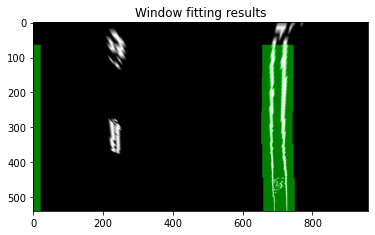

In [25]:
template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channel
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

#Visualize the results of the window fitting to lane lines
plt.imshow(result, cmap='gray')
plt.title('Window fitting results')
plt.show()

In [12]:
yvals

NameError: name 'yvals' is not defined

In [ ]:
res_yvals

In [ ]:
left_fit

In [ ]:
leftx

In [ ]:
np.polyfit(res_yvals, leftx, 3)

In [ ]:
left_fitx

In [ ]:
yvals = range(0,warped.shape[0])

res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

left_fit = np.polyfit(res_yvals, leftx, 2)
left_fit

In [ ]:
left_fit[0]

In [ ]:
left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
left_fitx

In [ ]:
left_fitx = np.array(left_fitx,np.int32)

right_fit = np.polyfit(res_yvals, rightx, 2)
right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
right_fitx = np.array(right_fitx,np.int32)

left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
